In [1]:
import sys
sys.path.append('../scripts/')

In [2]:
from dataclasses import dataclass
from file_utils import open_files
import file_names as FileNames
from file_utils import open_files 
from fits_extractor import load_event_file, split_events_by_CCD, get_gti_from_file
from renderer import *
from variability_utils import variability_computation, variable_areas_detection, variable_sources_position
import matplotlib.pyplot as plt

2023-12-14 16:09:33,214 - DEBUG - __init__.py:wrapper - matplotlib data path: /home/nkhan/EXOD/venv/lib/python3.12/site-packages/matplotlib/mpl-data
2023-12-14 16:09:33,226 - DEBUG - __init__.py:wrapper - CONFIGDIR=/home/nkhan/.config/matplotlib
2023-12-14 16:09:33,230 - DEBUG - __init__.py:<module> - interactive is False
2023-12-14 16:09:33,231 - DEBUG - __init__.py:<module> - platform is linux
2023-12-14 16:09:33,334 - DEBUG - __init__.py:wrapper - CACHEDIR=/home/nkhan/.cache/matplotlib
2023-12-14 16:09:33,338 - DEBUG - font_manager.py:_load_fontmanager - Using fontManager instance from /home/nkhan/.cache/matplotlib/fontlist-v330.json


In [3]:
%matplotlib inline

2023-12-14 16:09:34,768 - DEBUG - pyplot.py:switch_backend - Loaded backend module://matplotlib_inline.backend_inline version unknown.


In [4]:
@dataclass
class Args:
    path: str
    out: str
    bs: int
    dl: float
    tw: float
    gtr: float
    mta: int
    creator: str
    obs: str
    inst: str
    render: bool
    ds9: bool
    novar: bool
    evts: str
    gti: str
    img: str

# Example usage:
args = Args(
    path="../example/0001730201/",
    out="../data/",
    bs=3,
    dl=10,
    tw=100.0,
    gtr=1.0,
    mta=8,
    creator="nkhan",
    obs="0001730201",
    inst="PN",
    render=False,
    ds9=False,
    novar=False,
    evts="../example/0001730201/PN_clean.fits",
    gti="../example/0001730201/PN_gti.fits",
    img="../example/0001730201/PN_image.fits"
)

In [5]:
def variable_areas_to_xyz(variable_areas_array):
    """
    Parameters
    ----------
    variable_areas : output from variable_areas_detection()
    num : index to get
    
    Convert the output from variable_areas_detection into 
    np arrays of x, y, z 
    """
    xs = [j[0] for j in variable_areas_array]
    ys = [j[1] for j in variable_areas_array]
    zs = [j[2] for j in variable_areas_array]
    
    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)
    return xs, ys, zs

In [6]:
# Get the file paths for the output files
var_f, reg_f, best_match_f = open_files(args.out)

2023-12-14 16:09:34,797 - INFO - file_utils.py:open_files - Creating ../data/ if it doesn't exist...
2023-12-14 16:09:34,798 - INFO - file_utils.py:open_files - var_file=../data/variability_file.fits reg_file=../data/ds9_variable_sources.reg best_match_file=../data/best_match.csv


In [7]:
# Extract Photons from event list and group them by the 12 CCDs
# Returns a list of np.arrays()
events, header = load_event_file(args.evts)
data = split_events_by_CCD(events)

In [8]:
# Obtain the good time intervals from the GTI .fits file
# '../example/0001730201/PN_gti.fits'
# Returns [(start, stop), [(tart, stop)] as a FITS_rec
gti_list = get_gti_from_file(args.gti)

2023-12-14 16:09:34,890 - DEBUG - fits_extractor.py:get_gti_from_file - Getting GTIs from file=../example/0001730201/PN_gti.fits


In [9]:
# Literally getting the start and end times of the event list,
# if the event list wasn't cut-up you wouldn't have to do this
# in such a confusing way
t0_observation = min(events["TIME"])
tf_observation = max(events["TIME"])

In [10]:
CCD_NUMBER       = 3 # Use the CCD with the bright source on it

# Variability Computation for 1 CCD
v = variability_computation(gti=gti_list,
                            time_interval=args.tw,
                            acceptable_ratio=args.gtr,
                            start_time=t0_observation,
                            end_time=tf_observation,
                            inst=args.inst,
                            box_size=args.bs,
                            data=data[CCD_NUMBER])

# Variable area compuation for 1 CCD
# Manually adjusting settings to get a result
detection_level_ = 5 # The detection level is used in variable_areas_detection
lower_limit_     = np.median(v) # Set the lower limit 
va = variable_areas_detection(lower_limit=lower_limit_,
                              box_size=args.bs,
                              detection_level=detection_level_,
                              inst=args.inst,
                              variability_matrix=v)

2023-12-14 16:09:34,955 - DEBUG - variability_utils.py:variability_computation - gti: [(1.00532388e+08, 1.00533588e+08) (1.00533688e+08, 1.00537888e+08)
 (1.00537988e+08, 1.00538688e+08) (1.00538888e+08, 1.00538988e+08)
 (1.00543488e+08, 1.00543588e+08) (1.00544188e+08, 1.00544288e+08)
 (1.00544688e+08, 1.00544788e+08) (1.00544988e+08, 1.00548088e+08)
 (1.00548188e+08, 1.00548988e+08) (1.00549088e+08, 1.00555188e+08)]
2023-12-14 16:09:34,957 - DEBUG - variability_utils.py:variability_computation - time_interval: 100.0
2023-12-14 16:09:34,957 - DEBUG - variability_utils.py:variability_computation - acceptable_ratio: 1.0
2023-12-14 16:09:34,958 - DEBUG - variability_utils.py:variability_computation - start_time: 100532388.34954765
2023-12-14 16:09:34,959 - DEBUG - variability_utils.py:variability_computation - end_time:100555147.36131173
2023-12-14 16:09:34,959 - DEBUG - variability_utils.py:variability_computation - inst:PN
2023-12-14 16:09:34,960 - DEBUG - variability_utils.py:variabil

In [11]:
# Calculate Position of Variable Sources
sources = variable_sources_position(
          variable_areas_matrix=va,
          obs=args.obs,
          inst=args.inst,
          path_out=args.path,
          reg_file=reg_f,
          img_file=args.img,
          best_match_file=best_match_f,
          bs=args.bs,
          dl=args.dl,
          tw=args.tw,
          gtr=args.gtr
          )

2023-12-14 16:09:49,052 - DEBUG - variability_utils.py:variable_sources_position - Computing Source position...


TypeError: 'int' object is not subscriptable

2023-12-14 16:17:47,823 - DEBUG - colorbar.py:_get_ticker_locator_formatter - locator: <matplotlib.ticker.AutoLocator object at 0x7f7b94a01070>


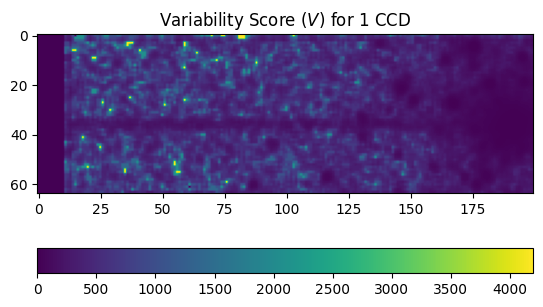

In [14]:
plt.title(r'Variability Score ($V$) for 1 CCD')
plt.imshow(v)
plt.colorbar(orientation='horizontal')
plt.show()

In [15]:
fig, ax = plt.subplots(len(v_matrix)//2, 2, figsize=(15,15))
axes = ax.flatten()
pn_order = [12,3,11,2,10,1,7,4,8,5,9,6] #i hate it
for i in range(12):
    
    #j = pn-1
    #v_ = v_matrix[j]
    #print(i,pn,j)
    #if i%2==0:
    #v_ = np.fliplr(v_)
        
    im = axes[i].imshow(v_matrix[i], interpolation='none', cmap='viridis')
    fig.colorbar(im, ax=axes[i], orientation='horizontal')
    axes[i].set_title(f'CCD NUMBER={i+1}', color='red')
    axes[i].set_xticks([])
    axes[i].set_yticks([])
    
#plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

NameError: name 'v_matrix' is not defined

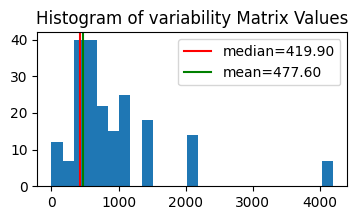

In [16]:
# Currently, in detector.py, the median is then calculated over all variability arrays
# then this value of the median is used for the lower limit in the variable_areas detection, this is completley
# scuffed as the variability score for each CCD can vary greatly (the on with the readout streak
# for example has values of ~4000 while the others are around ~400 this means that certain CCDs
# essentially get no variable areas detected what-so-ever.
# Additionally, a hard limit of 0.75 was imposed for the variabilty lower limit, which is likely to not even matter
# anyway. Another point is that a single detection limit that is placed at the start of the script
# does not adapt to the variability scores that differ from ccd to ccd...

median = np.median(v)
mu = np.mean(v)
plt.figure(figsize=(4,2))
plt.title('Histogram of variability Matrix Values')
plt.hist(v[0], bins=25)
plt.axvline(median, color='red', label=f'median={median:.2f}')
plt.axvline(mu, color='green', label=f'mean={mu:.2f}')
plt.legend()

In [17]:
variable_areas = [variable_areas_detection(lower_limit=median,
                                           box_size=args.bs,
                                           detection_level=args.dl,
                                           inst=args.inst,
                                           variability_matrix=v) for v in v_matrix]

NameError: name 'v_matrix' is not defined

In [18]:
variable_areas_to_xyz(variable_areas[3])

NameError: name 'variable_areas' is not defined

NameError: name 'v_matrix' is not defined

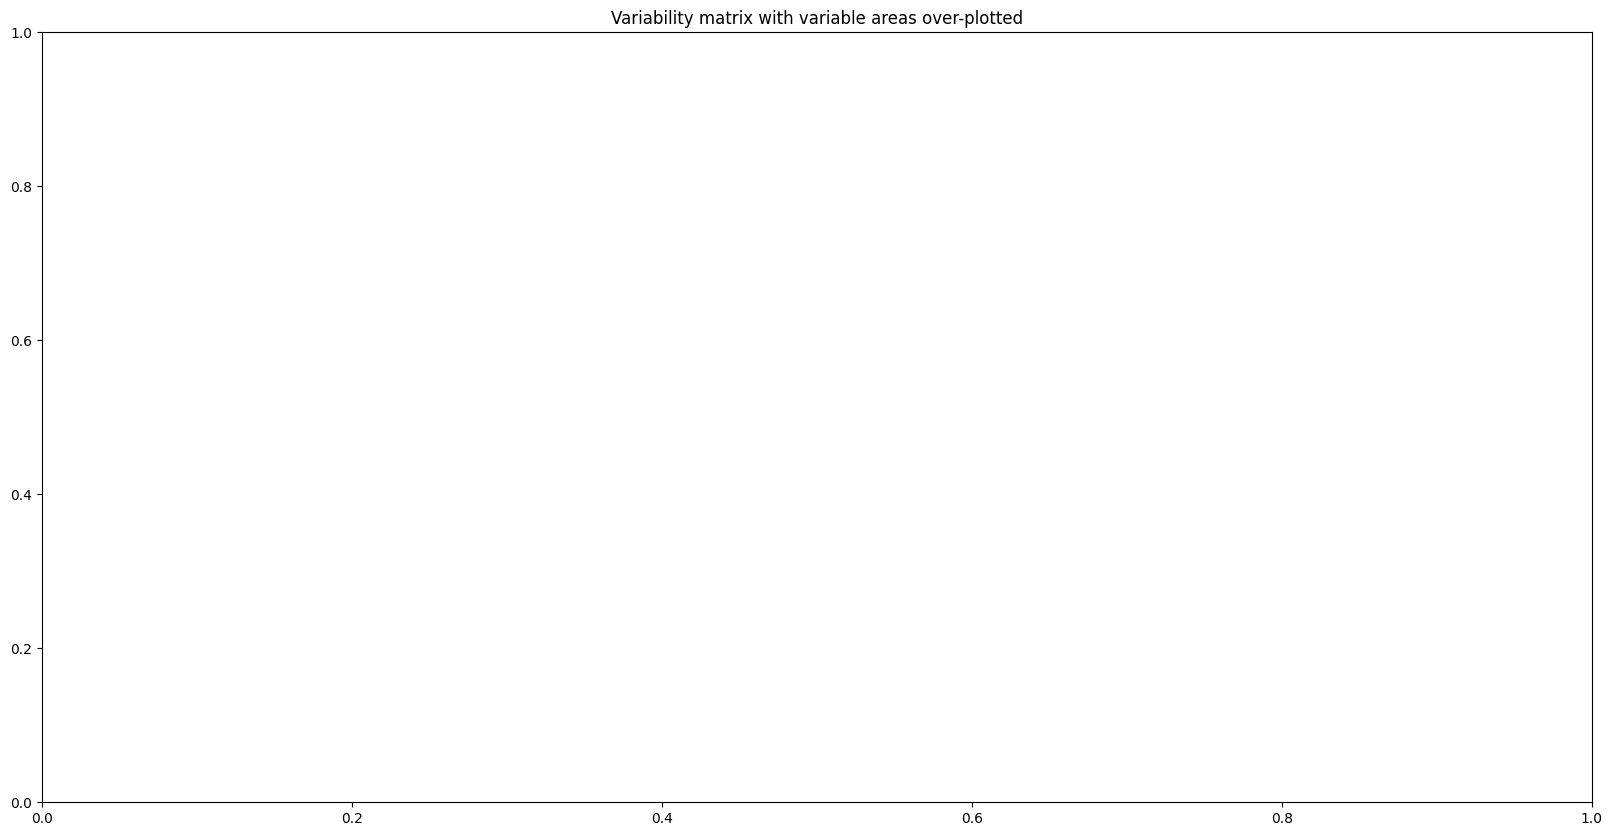

In [19]:
plt.figure(figsize=(20,10))
plt.title('Variability matrix with variable areas over-plotted')
plt.imshow(v_matrix[3], interpolation='none', origin='lower')
plt.scatter(ys, xs, c=zs, s=5, marker='.', cmap='magma')

In [20]:
plt.figure(figsize=(4,2))
plt.hist(zs, bins=30)
plt.title('distribution of V for variable areas')

NameError: name 'zs' is not defined

<Figure size 400x200 with 0 Axes>